# Оглавнение

- [Вступление](#intro)
- [Подготовка данных](#preparation)
  - [Выводы по подготовке](#prep_conclusion)
- [Исследование задачи](#research)
  - ["Глупая" модель](#dummy)
  - [Логистическая Регресия](#lr)
  - [Древо Решений](#dt)
  - [Случайный Лес](#rf)
  - [Кросс-валидация](#cv)
  - [Выводы по исследованию](#res_coclusion)
- [Борьба с дисбалансом](#balance)
  - [Upsampling](#upsampling)
  - [Downsampling](#downsampling)
  - [Промежуточный вывод](#int_conclusion)
  - [Порог классификации](#threshold)
  - [Выводы по балансировке](#balance_conclusion)
- [Тестирование модели](#test)
- [Выводы](#conclusion)

<a id='intro'></a>
## Вступление

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Перед нами стоит задача спрогнозировать отток клиентов из банка. В наличии имеем файл содержащий данные о поведении клиентов и факт их расторжения или нет договора с банком. Изучим имеющиеся данные, при необходимости сделаем предобработку и построим модель которая поможет предсказать уход клиента.

Нам поставили задачу добится значение F1-меры не менее 0.59 на тестовоый выборке.

<a id ='preparation'></a>
## Подготовка данных

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

**Читаем исходный файл**

In [2]:
data = pd.read_csv('Churn.csv')

**Основная информация о датафрейме**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


0    0.7963
1    0.2037
Name: Exited, dtype: float64


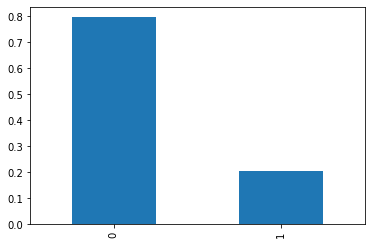

In [5]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

В данных содержится 10000 строк (клиентов). Есть 14 колонок. В одной колонке, `Tenure` есть пропуски, рассмотрим их. Колонка `Exited` является целевым признаком, проверили её на дисбаланс, данные в ней не сбалансированы 80/20. 80% это не ушедшие клиенты.

**Пропуски**

In [6]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
data['Tenure'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [8]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

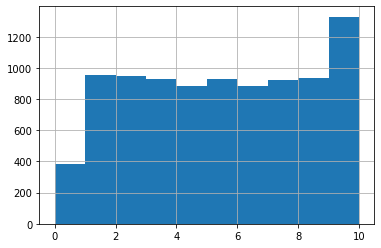

In [9]:
data['Tenure'].hist();

В столбце `Tenure` находится 909 пропусков. Столбец содержит целочисленные значения от 0 до 10. В диапазоне 2-9 количество значений находится примерно на одном уровне, около 900 строк. На 0 и 10 приходится меньше значений 382 и 446 соответсвенно.

Данная колонка показывает сколько лет пользователь является клиентом банка. Можем предположить что отсутсвующие значения это 0 лет, но если наше предположение не верно, то этим мы исказим изначальные данные для модели. Можём или оставить пропуски или удалить их, это примерно 9% от изначального колличества. Пропуски удалим, 9% конечно не мало, но и не критично.

In [10]:
data = data.dropna(subset=['Tenure']).reset_index(drop=True)

In [11]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Удаление ненужных данных**

Столбцы `RowNumber`, `CustomerId`, `Surname` нам не понадобятся, удалим их.

In [12]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1).reset_index(drop=True)

**Разбитие данных на выборки**

Целевой признак содержит колонка `Exited` в виде двух значений (0 - клиент не ушел и 1 - клиент ушел). Все остальные колонки будем использовать в качестве признаков.

Перед нами стоит задача классификации, данные содержат как категориальные признаки так и численные. С помощью прямого кодирования (**OHE**) преобразуем все категориальные в численные.

In [13]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [14]:
data_ohe.shape

(9091, 12)

In [15]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


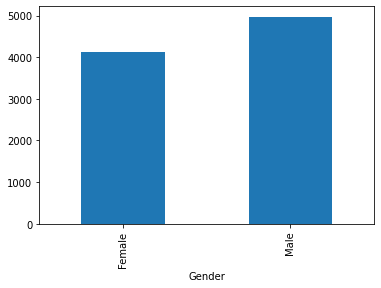

In [16]:
data.groupby('Gender')['Gender'].agg('count').plot(kind='bar');

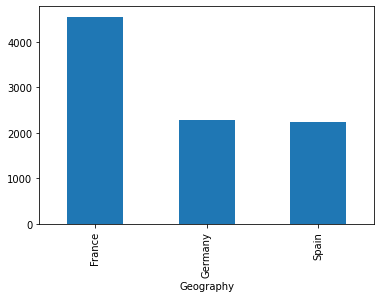

In [17]:
data.groupby('Geography')['Geography'].agg('count').plot(kind='bar');

Вместо столбца со страной проживания получили два (Germany и Spain) в которых в бинарном виде содержится информация о стране проживания, если в обоих стобцах стоят 0, значит страна проживания France.

Теперь имеем 12 колонок, все признаки стали численными. Можно начать разбивку, для начала выделим целевой признак.

In [18]:
features = data_ohe.drop('Exited', axis=1,)
target = data_ohe['Exited']

Из имеющихся данным нам нужно получить три выборки:

- Тренировочную: для обучения модели.
- Валидационную: с помощью которой мы будем проверять модель в процессе подборки гиперпараметров.
- Тестовую: на которой протестируем выбранную готовую модель.

Разделение произведём в соотношении 3:1:1, тоесть 60% - тренировочная выборка и по 20% валидационная и тестовая выборки.

In [19]:
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, train_size=0.6, random_state=12345, stratify=target)

In [20]:
print(features_train.shape)
print(features_rest.shape)
print(target_train.shape)
print(target_rest.shape)

(5454, 11)
(3637, 11)
(5454,)
(3637,)


In [21]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345, stratify=target_rest)

In [22]:
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(1818, 11)
(1819, 11)
(1818,)
(1819,)


In [23]:
features_train_val = pd.concat([features_train, features_valid])
target_train_val = pd.concat([target_train, target_valid])

In [24]:
print(features_train_val.shape)
print(target_train_val.shape)

(7272, 11)
(7272,)


Сделали разбитие, проверили размеры - всё корректно. Получили три выборки, а так же собрали четвертую соединив тренировочную и валидационную выборки. Данная выборка нам пригодится для подбора параметров с помощью кросс-валидации.

**Масштабирование**

Сделаем масштабирование признаков, для уравнивания их веса в процессе обучения модели.

In [25]:
numeric = ['CreditScore',
           'Age',
           'Tenure',
           'Balance',
           'NumOfProducts',
           'HasCrCard',
           'IsActiveMember',
           'EstimatedSalary',
          ]

In [26]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_val[numeric] = scaler.transform(features_train_val[numeric])

<a id='prep_conclusion'></a>
### Выводы по подготовке данных

Изучили полученные данные. 
- Обнаружили в них пропуски, от их пришлось избавится из-за невозможности их корректно восстановить. 
- В данных есть дисбаланс целевого признака - 80%/20%. В дальнейшем построим модели как учитывающие так и нет данный дисбаланс. 
- Удалили ненужные для построения модели стобцы - `RowNumber`, `CustomerId`, `Surname`.
- Преобразовали все категориальные признаки в численные с помощью техники прямого кодирования (OHE).
- Разбили данные на выборки в соотношении 3:1:1 (60%/20%/20%):
 - Тренировочная - для обучения модели (60%).
 - Валидационная - для проверки модели в процессе обучения и помощи в выборе гиперпараметров (20%).
 - Тестовая -  на которой мы будет проверять нашу готовую модель. (20%)
 - Так же сделали выборку для подбора и обучения модели с помощью кросс-валидации, для этой техники отдельная валидационная выборка не нужна, поэтому соединили тренировочную и валидационную.
- Сделали масштабирование признаков чтобы уровнять их вес.

<a id='research'></a>
## Исследование задачи

Подготовили данные для модели. На данный момент дисбаланс целевого признака проигнорировали. Посмотрим каких результатов мы сможем добится таким образом, а потом поработаем над балансировкой.

<a id='dummy'></a>
### "Глупая" модель

Для начала посмотрим на глупую модель, которая будет игнорировать входящие признаки, вместо этого предсказание будет делаться случайным образом. Гиперпараметр strategy укажем most_frequent, теперь модель будет всегда давать в качестве ответа самый часто встречающийся целовой признак в процессе обучения.

In [27]:
dummy = DummyClassifier(random_state=12345, strategy="most_frequent")
dummy.fit(features_train, target_train)
dummy_predicted_train = dummy.predict(features_train)
dummy_predicted_valid = dummy.predict(features_valid)

print('Тренировочная выборка:', dummy.score(features_train, target_train))
print('Валидационная выборка:', dummy.score(features_valid, target_valid))
print('F1:', f1_score(target_valid, dummy_predicted_valid))
print('Матрица ошибок:')
print(confusion_matrix(target_valid, dummy_predicted_valid))

Тренировочная выборка: 0.7961129446277961
Валидационная выборка: 0.7959295929592959
F1: 0.0
Матрица ошибок:
[[1447    0]
 [ 371    0]]


Данная модель показала accuracy 0.80 что ожидаемо из-за дисбаланса данных.

<a id='lr'></a>
### Логистическая Регрессия

Посмотрим какие результаты покажет логистическая регрессия.

Accuracy на валидационной выборке: 0.7095709570957096
F1 на валидационной выборке: 0.5065420560747663 

Матрица ошибок:
[[1019  428]
 [ 100  271]]


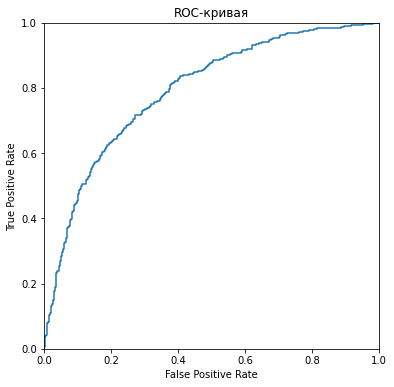

AUC-ROC на валидационной выборке: 0.7907260490614472


In [28]:
logreg_model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
logreg_model.fit(features_train, target_train)
logreg_predicted_valid = logreg_model.predict(features_valid)

probabilities_valid = logreg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy на валидационной выборке:', logreg_model.score(features_valid, target_valid))
print('F1 на валидационной выборке:', f1_score(target_valid, logreg_predicted_valid), '\n')
print('Матрица ошибок:' )
print(confusion_matrix(target_valid, logreg_predicted_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на валидационной выборке:', auc_roc_valid)

Логистическая регрессия на несбалансированной валидационной выборке показала следующие результаты:

- F1: **0.507**
- AUC-ROC: **0.791**

Данные результаты нас не устраивают, перейдём к древу решений.

<a id='dt'></a>
### Древо Решений

Подберём лучшие параметры для древа решений используя циклы.

Лучшая модель: DecisionTreeClassifier(max_depth=9, max_leaf_nodes=46, min_samples_leaf=10,
                       random_state=12345) 

F1 лучшей модели на валидационной выборке: 0.6094946401225114 

Матрица ошибок:
[[1373   74]
 [ 207  164]]


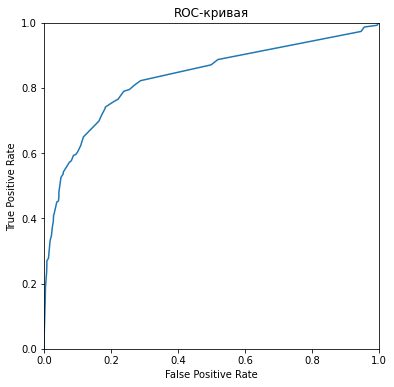

AUC-ROC на валидационной выборке: 0.8306348109388882
CPU times: total: 6min 33s
Wall time: 6min 33s


In [29]:
%%time

weights = ['balanced', None]

dt_model = None
dt_result = 0
for depth in range(1, 21):
    for leafs in range(2, 51):
        for samp_leafs in range(1, 21):
            for weight in weights:
                model = DecisionTreeClassifier(random_state=12345,
                                               class_weight=weight,
                                               max_depth=depth,
                                               max_leaf_nodes=leafs,
                                               min_samples_leaf=samp_leafs)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                result = f1_score(target_valid, predictions_valid)
                if result > dt_result:
                    dt_model = model
                    dt_result = result

probabilities_valid = dt_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("Лучшая модель:", dt_model, '\n')
print("F1 лучшей модели на валидационной выборке:", dt_result, '\n')
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predictions_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на валидационной выборке:', auc_roc_valid)

Древо решений со следующими параметрами: (max_depth=9, max_leaf_nodes=46, min_samples_leaf=10, random_state=12345) на несбалансированной валидационной выборке показало следующие результаты:

- F1: **0.609**
- AUC-ROC: **0.831**

Результаты уже лучше чем у логистической регресии. Перейдём к случайному лесу.

<a id='rf'></a>
### Случайный Лес

Подберём лучшие параметры для слуйного леса используя циклы.

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=230,
                       random_state=12345)

F1 лучшей модели на валидационной выборке: 0.6555697823303457

Матрица ошибок:
[[1394   53]
 [ 191  180]]


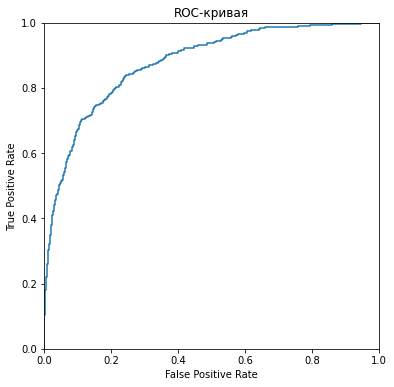

AUC-ROC на валидационной выборке: 0.8770259874039978
CPU times: total: 7min 8s
Wall time: 7min 8s


In [30]:
%%time

weights = ['balanced', None]

rf_model = None
rf_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 41, 2):
        for weight in weights:
            model = RandomForestClassifier(random_state=12345,
                                           class_weight=weight,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > rf_result:
                rf_model = model
                rf_result = result

probabilities_valid = rf_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("Лучшая модель:", rf_model)
print('')
print("F1 лучшей модели на валидационной выборке:", rf_result)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на валидационной выборке:', auc_roc_valid)

Случайный лес со следующими параметрами: (class_weight='balanced', max_depth=9, n_estimators=230, random_state=12345) на несбалансированной валидационной выборке показала следующие результаты:

- F1: **0.656**
- AUC-ROC: **0.877**

Результаты намного лучше чем у логистической регрессии и древа решений. Будем использовать случайный лес.

<a id='cv'></a>
### Кросс-валидация

Попробуем подобрать гиперпараметры для случйаного леса используя кросс-валидацию GridSearchCV.

In [31]:
n_estimators = []
max_depth = []


for est in range(100, 251, 10):
    n_estimators.append(est)
for depth in range(1, 21, 2):
    max_depth.append(depth)

In [32]:
rf = RandomForestClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'n_estimators': n_estimators,
    'max_depth': max_depth
         }

rf_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [33]:
%%time
rf_clf.fit(features_train_val, target_train_val)

CPU times: total: 16min
Wall time: 16min


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [34]:
print(rf_clf.best_estimator_)
print("F1 модели:", rf_clf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=230,
                       random_state=12345)
F1 модели: 0.6288849304871543


С помощью кросс-валидации получили те же параметры как и при переборе циклами. Случайный лес (class_weight='balanced', max_depth=9, n_estimators=230, random_state=12345)

<a id='res_coclusion'></a>
### Выводы по исследованию

На несбалансирвоанных данных проверили следующие модели: Логистическая Регрессия, Древо Решений, Случайный Лес. Лучший результат показал случайный лес. Так же использовали кросс-валидацию на случайном лесе и получили аналогичные результаты как и без неё.

Лучший результат на валидационной выборке на данный момент: **F1 - 0.656, AUC-ROC: 0.877**. Попробем поработать на балансировкой с целью улучшить результат.

<a id='balance'></a>
## Борьба с дисбалансом

Попробуем несколько вариантов балансировки, upsampling и downsampling.

<a id='upsampling'></a>
### Upsampling
С помощью этого метода мы увеличим в выборке количество класса который недостаточно представлен (1). Напишем функцию upsample.

In [35]:
def upsample(features, target, repeat): # В качестве аргументов функция будет принимать: признаки, целевой признак и во сколько раз умножить 1 класс
    features_zeros = features[target == 0] # Выделяем признаки 0 класса
    features_ones = features[target == 1] # Выделяем признаки 1 класса
    target_zeros = target[target == 0] # Выделяем целевой признак 0 класса
    target_ones = target[target == 1] # Выделяем целевой признак 1 класса

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # Умножаем признаки 1 класса и соединяем оба класса
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) # Умножаем целевой признак 1 класса и соединяем оба класса
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345) # Перемешиваем данные
    
    return features_upsampled, target_upsampled

Применим функцию для тестовой выборки и посмотрим на баланс классов.

In [36]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

In [37]:
features_train_val_upsampled, target_train_val_upsampled = upsample(features_train_val, target_train_val, 4)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

Теперь оба класса представлены равнозначно.

На увеличенной тестовой выборке подберём параметры для случайного леса.

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=200,
                       random_state=12345)

F1 лучшей модели на валидационной выборке: 0.6463104325699747

Матрица ошибок:
[[1345  102]
 [ 154  217]]


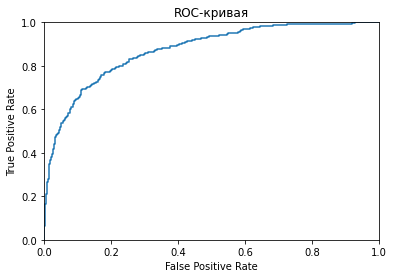

AUC-ROC на валидационной выборке: 0.8727639860888874
CPU times: total: 10min 7s
Wall time: 10min 7s


In [38]:
%%time

weights = ['balanced', None]

rf_upsampled_model = None
rf_upsampled_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 41, 2):
        for weight in weights:
                model = RandomForestClassifier(random_state=12345,
                                               class_weight=weight,
                                               n_estimators=est,
                                               max_depth=depth,)
                model.fit(features_upsampled, target_upsampled)
                predicted_valid = model.predict(features_valid)
                result = f1_score(target_valid, predicted_valid)
                if result > rf_upsampled_result:
                    rf_upsampled_model = model
                    rf_upsampled_result = result

probabilities_valid = rf_upsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("Лучшая модель:", rf_upsampled_model)
print('')
print("F1 лучшей модели на валидационной выборке:", rf_upsampled_result)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на валидационной выборке:', auc_roc_valid)

На сбалансированной с помощью увеличения выборки не удалось добится улучшения результатов на валидационной выборке.

Лучший результат у модели со следующими параметрами: (class_weight='balanced', max_depth=11, n_estimators=200, random_state=12345)

- F1: **0.646**
- AUC-ROC: **0.873**

Теперь попробуем подобрать параметры с помощью GridSearchCV.

In [39]:
rf_upsampled_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [40]:
%%time
rf_upsampled_clf.fit(features_train_val_upsampled, target_train_val_upsampled)

CPU times: total: 23min 20s
Wall time: 23min 20s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [41]:
print(rf_upsampled_clf.best_estimator_)
print("F1 модели:", rf_upsampled_clf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=120,
                       random_state=12345)
F1 модели: 0.9576759251596025


На сбалансированной с помощью увеличения выборки, кросс-валидацией удалось подобрать гиперпараметры на которых получаем результат **F1 - 0.958**

<a id='downsampling'></a>
### Downsampling

Попробуем уменьшить в выборке более представленный класс (0). Напишем функцию downsample.

In [42]:
def downsample(features, target, fraction): # В качестве аргументов функция будет принимать: признаки, целевой признак и какую долю от 0 класса оставить
    features_zeros = features[target == 0] # Выделяем признаки 0 класса
    features_ones = features[target == 1] # Выделяем признаки 1 класса
    target_zeros = target[target == 0] # Выделяем целевой признак 0 класса
    target_ones = target[target == 1] # Выделяем целевой признак 1 класса

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) # Методом pandas .sample оставим только указанную долю от 0 класса, после этого соединяем оба класса 
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) # Методом pandas .sample оставим только указанную долю от 0 класса, после этого соединяем оба класса
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345) # Перемешиваем данные
    
    return features_downsampled, target_downsampled

Применим функцию для тестовой выборки и посмотрим на баланс классов.

In [43]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.257)
target_downsampled.value_counts(normalize=True)

0    0.500898
1    0.499102
Name: Exited, dtype: float64

In [44]:
features_train_val_downsampled, target_train_val_downsampled = downsample(features_train_val, target_train_val, 0.257)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

Теперь оба класса представлены равнозначно.

На уменьшенной тестовой выборке подберём параметры для случайного леса.

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=160,
                       random_state=12345)

F1 лучшей модели на валидационной выборке: 0.623541887592789

Матрица ошибок:
[[1143  304]
 [  77  294]]


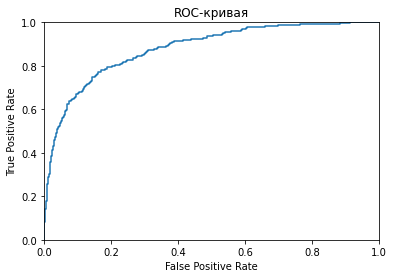

AUC-ROC на валидационной выборке: 0.8786186496087267
CPU times: total: 2min 43s
Wall time: 2min 43s


In [45]:
%%time

weights = ['balanced', None]

rf_downsampled_model = None
rf_downsampled_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 31, 2):
         for weight in weights:
            model = RandomForestClassifier(random_state=12345,
                                           class_weight=weight,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_downsampled, target_downsampled)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > rf_downsampled_result:
                rf_downsampled_model = model
                rf_downsampled_result = result

probabilities_valid = rf_downsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("Лучшая модель:", rf_downsampled_model)
print('')
print("F1 лучшей модели на валидационной выборке:", rf_downsampled_result)
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на валидационной выборке:', auc_roc_valid)

На сбалансированной с помощью уменьшения выборки не удалось добится улучшения результатов на валидационной выборке.

Лучший результат у модели со следующими параметрами: (class_weight='balanced', max_depth=13, n_estimators=160, random_state=12345)

- F1: **0.624**
- AUC-ROC: **0.879**

Теперь попробуем подобрать параметры с помощью GridSearchCV.

In [46]:
rf_downsampled_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [47]:
%%time
rf_downsampled_clf.fit(features_train_val_downsampled, target_train_val_downsampled)

CPU times: total: 8min 22s
Wall time: 8min 22s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [48]:
print(rf_downsampled_clf.best_estimator_)
print("F1 модели:", rf_downsampled_clf.best_score_)

RandomForestClassifier(max_depth=11, n_estimators=110, random_state=12345)
F1 модели: 0.7798260533363631


На сбалансированной с помощью уменьшения выборки, кросс-валидацией удалось подобрать гиперпараметры на которых получаем результат **F1 - 0.780**

<a id='int_conclusion'></a>
### Промежуточный вывод по балансировке

Попробовали сбалансировать выборку с помощью двух методов: увеличинием мало представленного класса(upsampling) и уменьшением более представленного класса(downsampling).

Удалось добиться улучшения только при подборе гиперпараметров с помощью кросс-валидации.
Лучший результат на тестовых данных получился при использовании upsampling и GridSearchCV. **F1 - 0.958**

<a id='threshold'></a>
### Измение порога классификации

Посмотрим, можем ли мы улучшить результаты на обученных моделей случайного леса с помощью изменения порога классификации.

In [49]:
probabilities_valid = rf_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.04 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.06 | Точность = 0.206, Полнота = 1.000, F1 = 0.341
Порог = 0.08 | Точность = 0.215, Полнота = 0.997, F1 = 0.354
Порог = 0.10 | Точность = 0.228, Полнота = 0.992, F1 = 0.371
Порог = 0.12 | Точность = 0.244, Полнота = 0.989, F1 = 0.391
Порог = 0.14 | Точность = 0.258, Полнота = 0.987, F1 = 0.409
Порог = 0.16 | Точность = 0.273, Полнота = 0.987, F1 = 0.428
Порог = 0.18 | Точность = 0.285, Полнота = 0.978, F1 = 0.442
Порог = 0.20 | Точность = 0.299, Полнота = 0.962, F1 = 0.456
Порог = 0.22 | Точность = 0.313, Полнота = 0.949, F1 = 0.471
Порог = 0.24 | Точность = 0.330, Полнота = 0.930, F1 = 0.487
Порог = 0.26 | Точность = 0.349, Полнота = 0.922, F1 = 0.506
Порог = 0.28 | Точность = 0.371, Полнота = 0.908, F1 = 0.527
Порог = 0.30 | Точность = 0.393, Полнота = 0.884, F1 = 0.544
Порог = 0.32 | Точность 

На моделе с дисбалансом стандартный порог 0.5 показывает лучшие результаты, **F1 - 0.656**

In [50]:
probabilities_valid = rf_upsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.04 | Точность = 0.207, Полнота = 1.000, F1 = 0.343
Порог = 0.06 | Точность = 0.220, Полнота = 0.995, F1 = 0.360
Порог = 0.08 | Точность = 0.233, Полнота = 0.995, F1 = 0.377
Порог = 0.10 | Точность = 0.247, Полнота = 0.992, F1 = 0.396
Порог = 0.12 | Точность = 0.264, Полнота = 0.989, F1 = 0.417
Порог = 0.14 | Точность = 0.275, Полнота = 0.981, F1 = 0.429
Порог = 0.16 | Точность = 0.288, Полнота = 0.970, F1 = 0.444
Порог = 0.18 | Точность = 0.297, Полнота = 0.951, F1 = 0.452
Порог = 0.20 | Точность = 0.309, Полнота = 0.943, F1 = 0.466
Порог = 0.22 | Точность = 0.327, Полнота = 0.935, F1 = 0.484
Порог = 0.24 | Точность = 0.342, Полнота = 0.925, F1 = 0.499
Порог = 0.26 | Точность = 0.363, Полнота = 0.900, F1 = 0.517
Порог = 0.28 | Точность = 0.387, Полнота = 0.881, F1 = 0.537
Порог = 0.30 | Точность = 0.404, Полнота = 0.865, F1 = 0.551
Порог = 0.32 | Точность 

На увеличенной выборке лучший результат так же со стандартным порогом 0.5, **F1 - 0.646**

In [51]:
probabilities_valid = rf_downsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, F1 = 0.339
Порог = 0.04 | Точность = 0.207, Полнота = 1.000, F1 = 0.344
Порог = 0.06 | Точность = 0.215, Полнота = 1.000, F1 = 0.354
Порог = 0.08 | Точность = 0.223, Полнота = 0.997, F1 = 0.365
Порог = 0.10 | Точность = 0.230, Полнота = 0.992, F1 = 0.374
Порог = 0.12 | Точность = 0.240, Полнота = 0.992, F1 = 0.386
Порог = 0.14 | Точность = 0.250, Полнота = 0.992, F1 = 0.399
Порог = 0.16 | Точность = 0.258, Полнота = 0.987, F1 = 0.408
Порог = 0.18 | Точность = 0.265, Полнота = 0.987, F1 = 0.418
Порог = 0.20 | Точность = 0.273, Полнота = 0.981, F1 = 0.427
Порог = 0.22 | Точность = 0.283, Полнота = 0.978, F1 = 0.439
Порог = 0.24 | Точность = 0.293, Полнота = 0.973, F1 = 0.450
Порог = 0.26 | Точность = 0.305, Полнота = 0.960, F1 = 0.463
Порог = 0.28 | Точность = 0.316, Полнота = 0.943, F1 = 0.473
Порог = 0.30 | Точность = 0.328, Полнота = 0.935, F1 = 0.486
Порог = 0.32 | Точность 

На уменьшенной выборке лучший результат с порогом 0.66, **F1 - 0.659**

<a id='balance_conclusion'></a>
### Выводы по балансировке

Лучшей моделью после балансировки оказалась - Случайный лес обученный на данных обработанных увеличением выборки и гиперпараметрами подобранными с помощью кроссвалидации.

Тестировали так же и уменьшении выборки и изменение порогов классификации, данные техники не дали значительного улучшения результатов по сравнению с несбалансированной выборкой.

<a id='test'></a>
## Тестирование модели

Выбрали следующую модель: ``RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=120, random_state=12345)`` обученную с помощь GridSearchCV на 80% от изначальных данных и сбалансированных с помощью **upsamling** техники, остальные 20% мы выделили для тестовой выборки, которую будем теперь использовать.

Accuracy на тестовой выборке: 0.8521165475536009
F1 на тестовой выборке: 0.6072992700729928

Матрица ошибок:
[[1342  106]
 [ 163  208]]


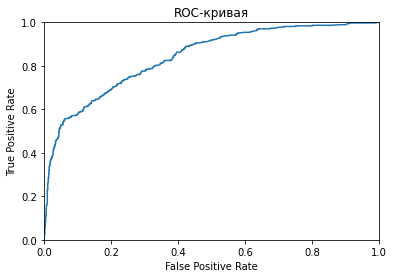

AUC-ROC на тестовой выборке: 0.8410327098628464


In [52]:
predicted_test = rf_upsampled_clf.predict(features_test)


probabilities_test = rf_upsampled_clf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print('Accuracy на тестовой выборке:', accuracy_score(target_test, predicted_test))
print('F1 на тестовой выборке:', f1_score(target_test, predicted_test))
print('')
print('Матрица ошибок:')
print(confusion_matrix(target_test, predicted_test))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на тестовой выборке:', auc_roc_test)

На тестовой выборке получили следующие результаты:
- F1:  **0.607**
- AUC-ROC: **0.841**
- Accuracy: **0.852**

Сравним с "глупой" моделью.

Accuracy: 0.7960417811984607
F1: 0.0
Матрица ошибок:
[[1448    0]
 [ 371    0]]


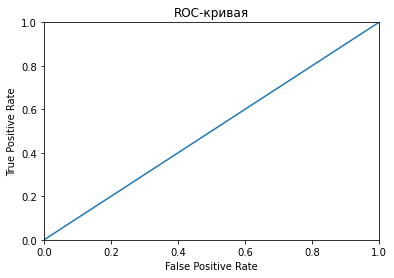

AUC-ROC на тестовой выборке: 0.5


In [53]:
dummy = DummyClassifier(random_state=12345, strategy="most_frequent")
dummy.fit(features_train, target_train)

dummy_predicted_test = dummy.predict(features_test)

probabilities_test = dummy.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print('Accuracy:', dummy.score(features_test, target_test))
print('F1:', f1_score(target_test, dummy_predicted_test))
print('Матрица ошибок:')
print(confusion_matrix(target_test, dummy_predicted_test))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('AUC-ROC на тестовой выборке:', auc_roc_test)

Результаты полученные с помощью выбранной модели на тестовой выборке нас устраивают.

<a id='conclusion'></a>
## Выводы

Перед нами стояла задача классификации с известным целевым признаком. Исследовали полученные данные: обработали их, удалили ненужные данные, разбили на выборки необходимые для обучения и тестирования модели. В процессе исследования обнаружили дисбаланс целевого признака, проверили как модели обучатся без учёта данного дисбаланса. 

Тестировали следующие модели: Логистическа Регрессия, Древо Решений, Случайный лес. В ходе тестирования остановились на использовании случайного леса, остальные модели показывали значительно худшие результаты. К подбору оптимальных гиперпараметров подошли двумя способами: перебором с помощью циклов и кросс-валидацией GridSearchCV. На несбалансированных данных результаты полученные двумя этими способами были схожие.

После этого приступили к балансировке. Пробовали сбалансировать двумя техниками: Upsampling и Downsampling. Так же пробовали менять порог классификации, но этим способом не удалось достичь лучших результатов. Остановились на модели обучнной на upsampling выборке с помощью кросс-валидации. Удалось достичь следующих результатов на тестовой выборке: 

- F1:  **0.607**
- AUC-ROC: **0.841**
- Accuracy: **0.852**

Модель проверили на адекватность, сравнив с "глупой" моделью, предсказывающей только наиболее всречающийся признак в процеесе обучения модели. Наша модель проверку прошла.

Наша модель может с хорошей точностью корректно предсказывать расторжение доровора клиента с банком.